------
# Introdução

> Olá! Seja bem-vindo.
> 
> Quem nunca ficou curioso por tentar prever o valor da gasolina amanhã? Será possível? Esse projeto terá esse objetivo.
> Iremos analisar dados históricos desses valores, mais precisamente um recorte do ano de 2013 até 2020. Analisando possíveis padrões existentes.
>
> `Links dos Dados Originais:`
> 
> [Série Histórica Combustíveis](https://dados.gov.br/dados/conjuntos-dados/serie-historica-de-precos-de-combustiveis-e-de-glp)

# Importando Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import datetime as dt
import time
import scipy
import requests
from bs4 import BeautifulSoup as bs4

# Carregando Dados e criando Funções (Leitura e Ajustes)

In [2]:
def read_data(tipo_produto: str, path: str):
    files_name = os.listdir(path)
    df = pd.DataFrame()
    
    for file in files_name:
        df_temp = pd.read_csv(path + file, sep=';', parse_dates=True, encoding='latin-1', low_memory=False)
        df = pd.concat([df, df_temp])
    
    df = df.drop(columns=['Nome da Rua', 'Numero Rua', 'Complemento', 'Cep', 'Unidade de Medida'])
    nomes_colunas = {
                    'Estado - Sigla':'EstadoSigla',
                    'Municipio':'Municipio',
                    'Revenda':'Revenda',
                    'CNPJ da Revenda':'CNPJRevenda',
                    'Bairro':'Bairro',
                    'Produto':'Produto',
                    'Data da Coleta':'DataColeta',
                    'Valor de Venda':'ValorVenda',
                    'Valor de Compra':'ValorCompra',
                    'Bandeira':'Bandeira'
                     }

    df = df.rename(columns=nomes_colunas)
    df['Produto'] = df['Produto'].str.upper()
    return df.loc[df['Produto']==tipo_produto]

def float_converter(colunas, dataframe):
    for coluna in colunas:
        try:
            dataframe[coluna] = dataframe[coluna].str.replace(',','.').astype(float)
            print(f'{coluna} convertido com sucesso para {column_type}')
        except:
            column_type = type(dataframe[coluna].dtype)
            print(f'Uma excessão ocorreu porque {coluna} é do tipo {column_type}')
            
def add_dates(colunas, dataframe):
    for coluna in colunas:
        dataframe[coluna] = pd.to_datetime(dataframe[coluna],format='mixed')
        dataframe['mes'] = dataframe[coluna].dt.month.astype(int)
        dataframe['ano'] = dataframe[coluna].dt.year.astype(int)
        dataframe['dia'] = dataframe[coluna].dt.day.astype(int)
    return 'Datas Adicionadas'
        
def add_mrg(coluna_venda, coluna_compra, dataframe):
    dataframe['mrg'] = (dataframe[coluna_venda] - dataframe[coluna_compra])/dataframe[coluna_venda]
    return 'Coluna Margem Adicionada'    


In [3]:
#Código Hexadecimal de cores
cor_roxo_padrao = '#5b6aea'
cor_roxo_claro = '#8c96f0'
cor_roxo_escuro = '#1b1f46'

In [4]:
combustiveis = read_data('GASOLINA', path = '/media/jorge/HDD/Python/combustiveis/dados_historicos/')

#Conversões de tipo de dados
float_converter(['ValorCompra','ValorVenda'], combustiveis)
add_dates(['DataColeta'], combustiveis)

#Calculando Margem de lucro
add_mrg('ValorVenda', 'ValorCompra', combustiveis)

Uma excessão ocorreu porque ValorCompra é do tipo <class 'numpy.dtypes.Float64DType'>
ValorVenda convertido com sucesso para <class 'numpy.dtypes.Float64DType'>


'Coluna Margem Adicionada'

In [5]:
colunas_quantitativas = ['ValorVenda', 'ValorCompra', 'mrg']

In [25]:
combustiveis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2703118 entries, 0 to 431575
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ï»¿Regiao - Sigla  object        
 1   EstadoSigla        object        
 2   Municipio          object        
 3   Revenda            object        
 4   CNPJRevenda        object        
 5   Bairro             object        
 6   Produto            object        
 7   DataColeta         datetime64[ns]
 8   ValorVenda         float64       
 9   ValorCompra        float64       
 10  Bandeira           object        
 11  Regiao - Sigla     object        
 12  mes                int64         
 13  ano                int64         
 14  dia                int64         
 15  mrg                float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(9)
memory usage: 350.6+ MB


# Visão Geral dos Dados

In [6]:
combustiveis.isnull().sum()

ï»¿Regiao - Sigla     119166
EstadoSigla                0
Municipio                  0
Revenda                    0
CNPJRevenda                0
Bairro                  8729
Produto                    0
DataColeta                 0
ValorVenda                 0
ValorCompra          1777820
Bandeira                   0
Regiao - Sigla       2583952
mes                        0
ano                        0
dia                        0
mrg                  1777820
dtype: int64

In [7]:
combustiveis[colunas_quantitativas].describe().round(3)

,ValorVenda,ValorCompra,mrg
count,2703118.000,925298.000,925298.000
mean,4.165,3.189,0.130
std,1.149,0.627,0.039
min,2.229,2.025,-0.163
25%,3.199,2.564,0.103
50%,3.989,3.170,0.129
75%,4.699,3.710,0.155
max,8.990,5.091,0.414


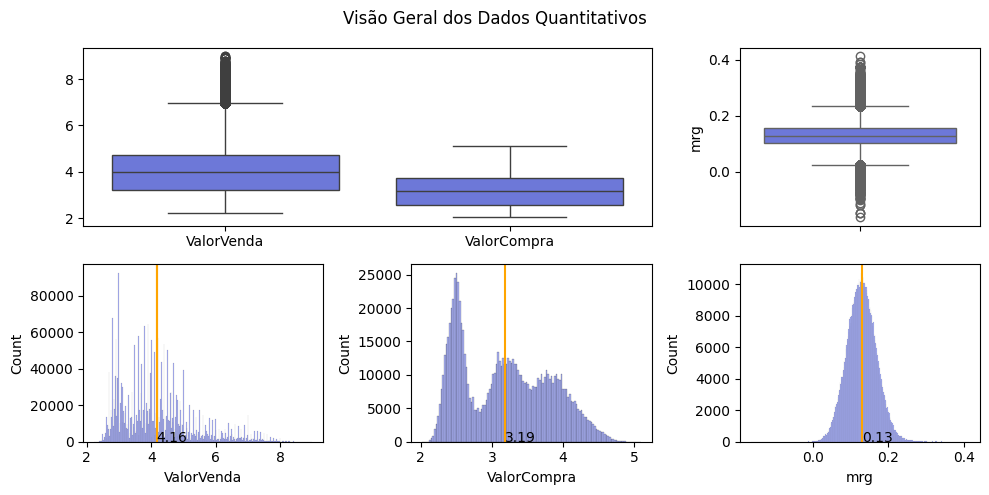

In [8]:
plt.figure(figsize = (10, 5)).suptitle('Visão Geral dos Dados Quantitativos')

plt.subplot(2, 3, (1, 2))
sb.boxplot(combustiveis[colunas_quantitativas[0:2]], color = cor_roxo_padrao)

plt.subplot(2, 3, (3))
sb.boxplot(combustiveis[colunas_quantitativas[-1]], color = cor_roxo_padrao)

plt.subplot(2, 3, (4))
sb.histplot(combustiveis['ValorVenda'], color = cor_roxo_claro)
media = combustiveis['ValorVenda'].mean()
plt.axvline(media, color = 'orange')
plt.text(x = media, y = 0, s = round(media, 2))
plt.axvline(media, color = 'orange')

plt.subplot(2, 3, (5))
sb.histplot(combustiveis['ValorCompra'], color = cor_roxo_claro)
media = combustiveis['ValorCompra'].mean()
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')

plt.subplot(2, 3, (6))
sb.histplot(combustiveis['mrg'], color = cor_roxo_claro)
media = combustiveis['mrg'].mean()
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')

plt.tight_layout()
plt.savefig('visao_geral_dados_quant.png', dpi = 150)
plt.show()

## Distribuição dos Dados - Geral
>Já observamos alguns pontos interessantes.
>  
>- Temos um pico nos valores a esquerda da nossa distribuição deos valores de venda e compra (valores mais baixos).
>  
>- Temos uma amplitude alta nesse contexto, variamos de valores de compra de `R$2,025` para `R$5,091` e na venda de `R$2,229` para `R$5,799`.
>  
>- Essa variação faz com que **não possamos tomar a `média geral de compra e venda` como um boa representação dos nossos dados. Pelo menos não no cenário geral**
>
>- Contundo, a `margem de lucro` possui uma distribuição muito semelhamente a uma distribuição normal, e uma bastante estreita, o que indica que temos muitos valores em torno de uma mesma média, 13% (0.13) nesse caso. Lembrando que o pandas/seaborn/matplotlib por padrão ignora valores nulos (N/A) no momento de criar essas visualizações. Mas como já tiramos os valores nulos anteriormente, isso não será algo a se preocupar
>
>Vamos estratificar essas distribuições em busca de outras visualizações.

# Visualização das Distribuições de dados

In [9]:
combustiveis_antes_2016 = combustiveis.loc[combustiveis.ano <= 2015]
combustiveis_depois_2016 = combustiveis.loc[combustiveis.ano > 2015]

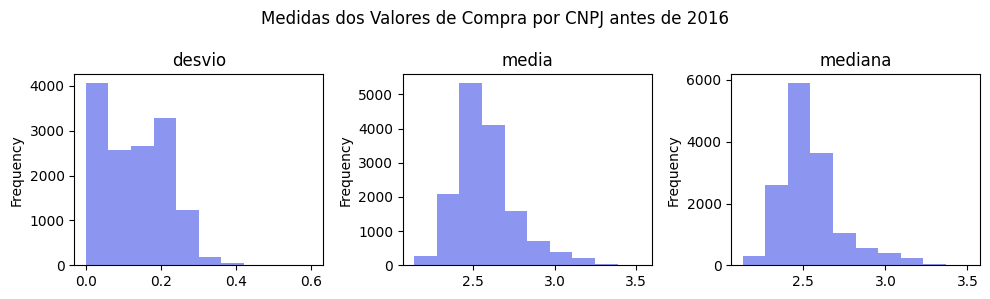

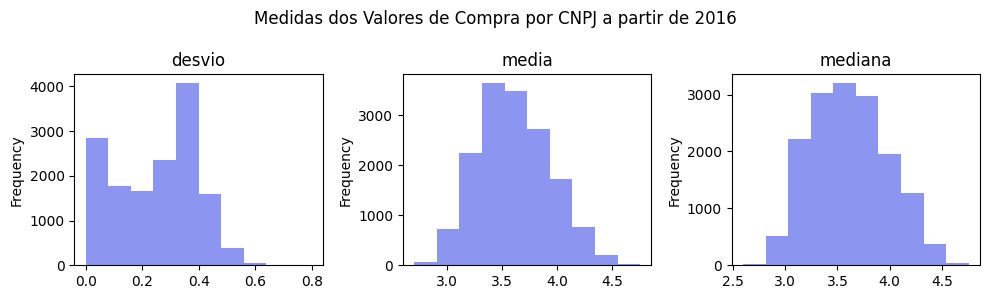

In [10]:
desvios_cnpjs = combustiveis_antes_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].std()
mean_cnpjs = combustiveis_antes_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].mean()
median_cnpjs = combustiveis_antes_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por CNPJ antes de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.tight_layout()
plt.savefig('medidas_cnpj_antes_2016.png', dpi = 150)
plt.show()

#==========================================================================================================================================

desvios_cnpjs = combustiveis_depois_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].std()
mean_cnpjs = combustiveis_depois_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].mean()
median_cnpjs = combustiveis_depois_2016.groupby(by = 'CNPJRevenda')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por CNPJ a partir de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_cnpjs.plot(kind = 'hist', color = cor_roxo_claro)

plt.tight_layout()
plt.savefig('medidas_cnpj_depois_2016.png', dpi = 150)
plt.show()

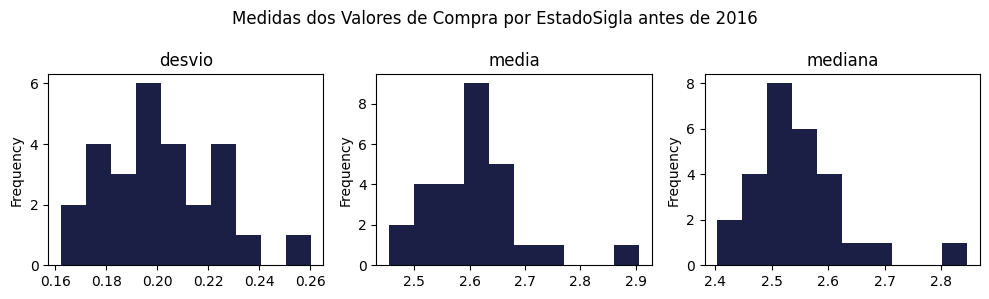

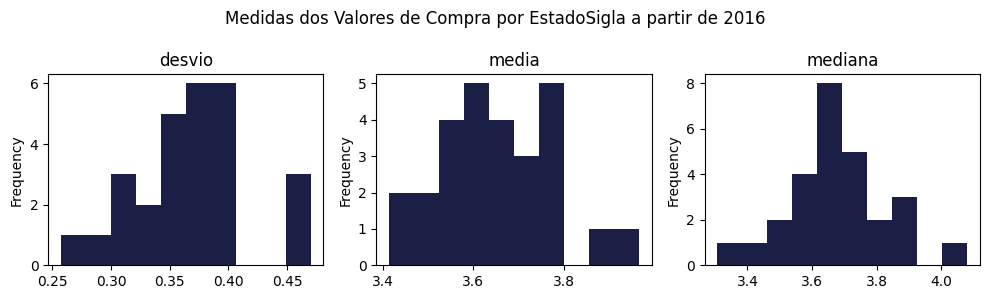

In [11]:
desvios_uf = combustiveis_antes_2016.groupby(by = 'EstadoSigla')['ValorCompra'].std()
mean_uf = combustiveis_antes_2016.groupby(by = 'EstadoSigla')['ValorCompra'].mean()
median_uf = combustiveis_antes_2016.groupby(by = 'EstadoSigla')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por EstadoSigla antes de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.tight_layout()
plt.savefig('medidas_uf_antes_2016.png', dpi = 150)
plt.show()

#======================================================================================================================

desvios_uf = combustiveis_depois_2016.groupby(by = 'EstadoSigla')['ValorCompra'].std()
mean_uf = combustiveis_depois_2016.groupby(by = 'EstadoSigla')['ValorCompra'].mean()
median_uf = combustiveis_depois_2016.groupby(by = 'EstadoSigla')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por EstadoSigla a partir de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 2)
plt.title('media')
mean_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_uf.plot(kind = 'hist', color = cor_roxo_escuro)

plt.tight_layout()
plt.savefig('medidas_uf_depois_2016.png', dpi = 150)
plt.show()

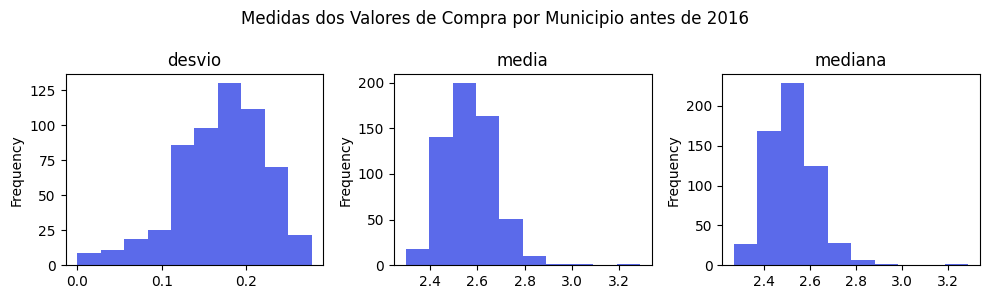

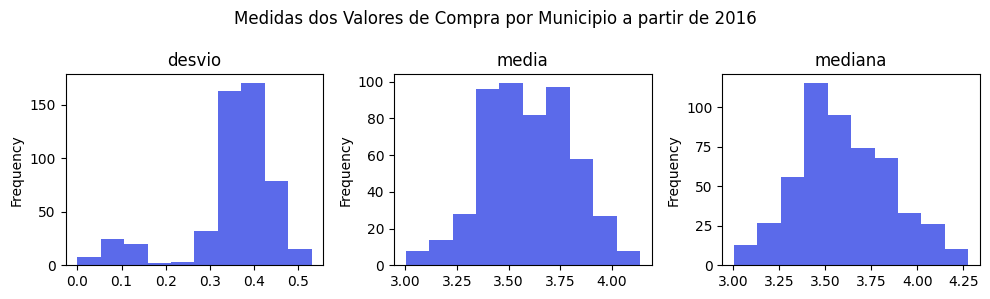

In [12]:
desvios_municipio = combustiveis_antes_2016.groupby(by = 'Municipio')['ValorCompra'].std()
mean_municipio = combustiveis_antes_2016.groupby(by = 'Municipio')['ValorCompra'].mean()
median_municipio = combustiveis_antes_2016.groupby(by = 'Municipio')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por Municipio antes de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 2)
plt.title('media')
mean_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.tight_layout()
plt.savefig('medidas_municipio_antes_2016.png', dpi = 150)
plt.show()

#======================================================================================================================

desvios_municipio = combustiveis_depois_2016.groupby(by = 'Municipio')['ValorCompra'].std()
mean_municipio = combustiveis_depois_2016.groupby(by = 'Municipio')['ValorCompra'].mean()
median_municipio = combustiveis_depois_2016.groupby(by = 'Municipio')['ValorCompra'].median()

plt.figure(figsize=(10, 3)).suptitle('Medidas dos Valores de Compra por Municipio a partir de 2016')

plt.subplot(1, 3, 1)
plt.title('desvio')
desvios_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 2)
plt.title('media')
mean_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.subplot(1, 3, 3)
plt.title('mediana')
median_municipio.plot(kind = 'hist', color = cor_roxo_padrao)

plt.tight_layout()
plt.savefig('medidas_municipio_depois_2016.png', dpi = 150)
plt.show()

# Visualização da Série Temporal

### Evolução Geral

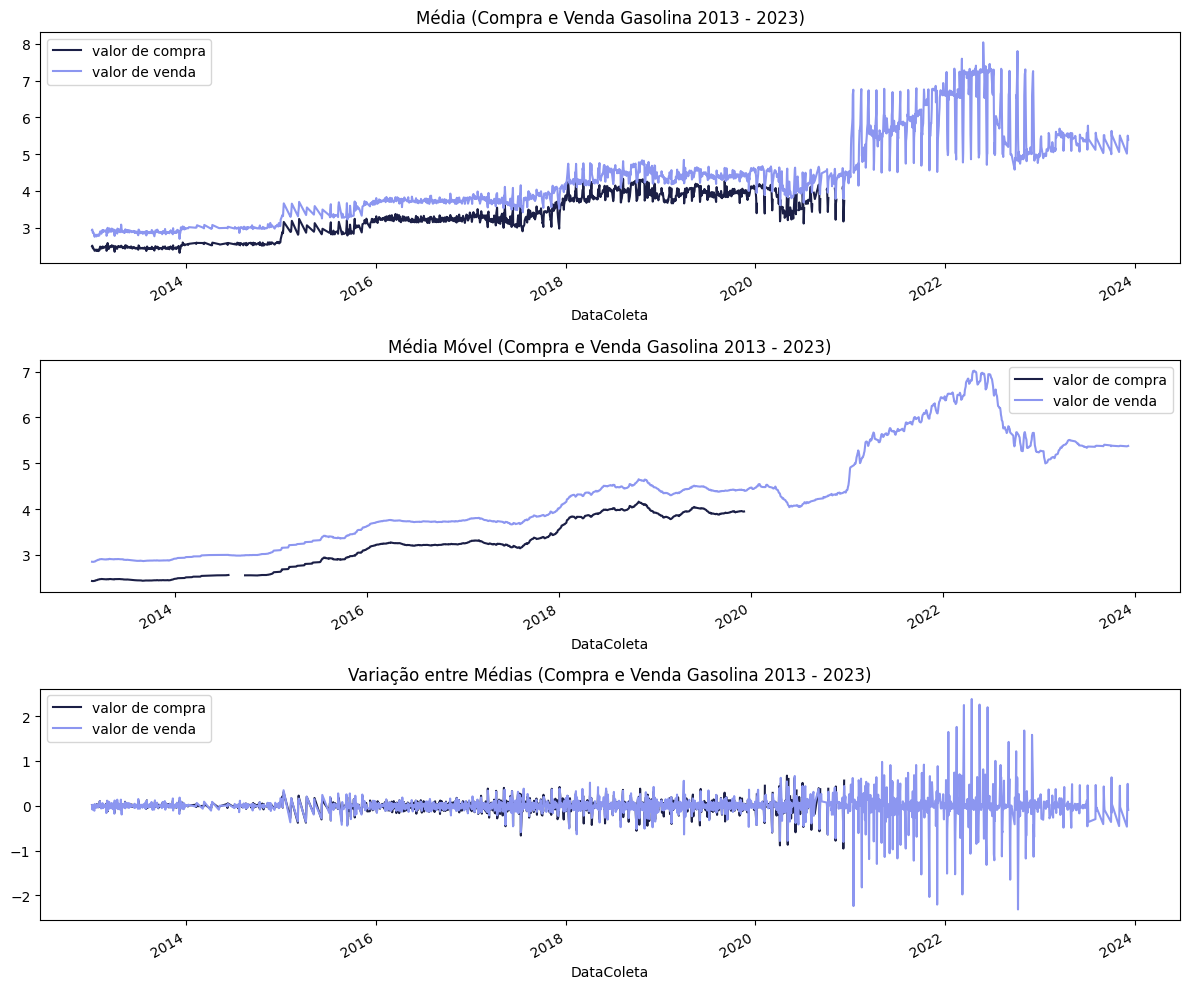

In [13]:
media_compra = combustiveis.groupby(by = 'DataColeta')['ValorCompra'].mean()
media_venda = combustiveis.groupby(by = 'DataColeta')['ValorVenda'].mean()

num_rows = 3
num_col = 1

plt.figure(figsize = (12, 10))

plt.subplot(num_rows, num_col, 1)
plt.title('Média (Compra e Venda Gasolina 2013 - 2023)')
media_compra.plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.subplot(num_rows, num_col ,2)
plt.title('Média Móvel (Compra e Venda Gasolina 2013 - 2023)')
media_compra.rolling(30).mean().plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.rolling(30).mean().plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.subplot(num_rows, num_col, 3)
plt.title('Variação entre Médias (Compra e Venda Gasolina 2013 - 2023)')
media_compra.diff().plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.diff().plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.tight_layout()
plt.savefig('analise_serie.png', dpi=150)
plt.show()


#### Conclusões
> - Os `valores de venda` acompanham de maneira quase idêntica a evolução dos `valores de compra`, o que indica que esse produto tende a seguir uma margem fixa de lucro. Isso pode nos auxiliar a lidar com os valores nulos encontrados anteriormente.
>
> - Até 2014 os números pareciam não sofrer grandes variações, em 2015 começamos a enxergar tendências de aumento, em 2016 o aumento se mostra mais e mais significativo.
>
> - Temos uma queda acentuada na metade do ano 2020.

### Evolução por estado (UF)

In [14]:
media_compra = combustiveis.groupby(by = ['DataColeta', 'EstadoSigla'])['ValorCompra'].mean()
media_venda = combustiveis.groupby(by = ['DataColeta', 'EstadoSigla'])['ValorVenda'].mean()

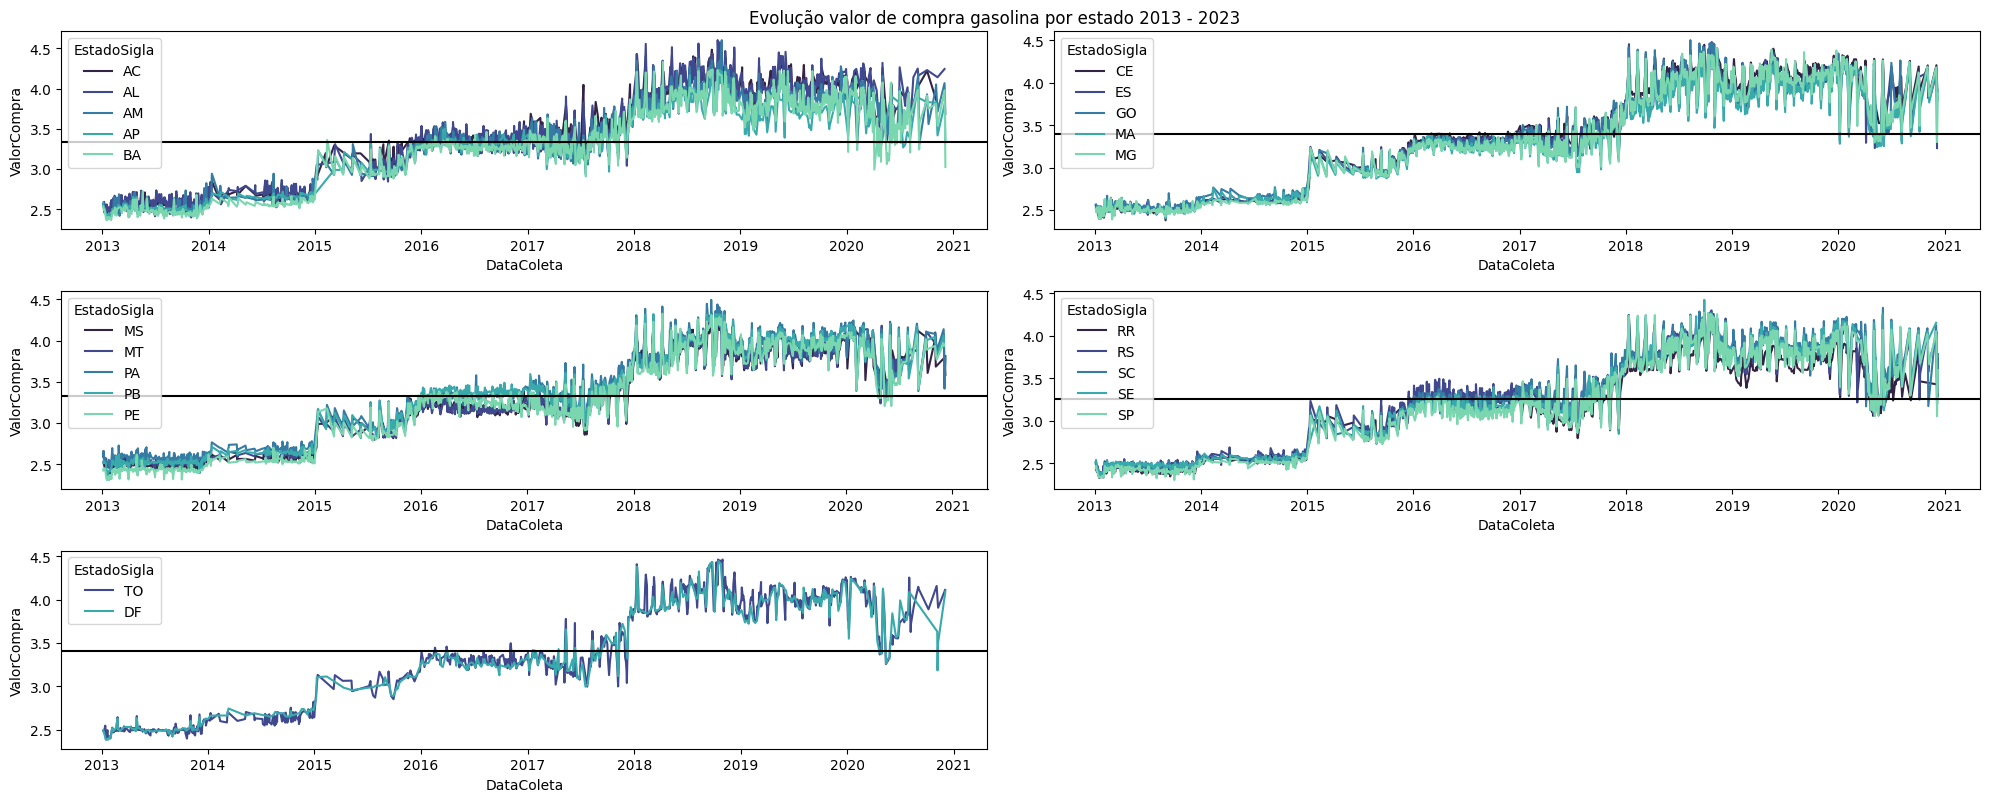

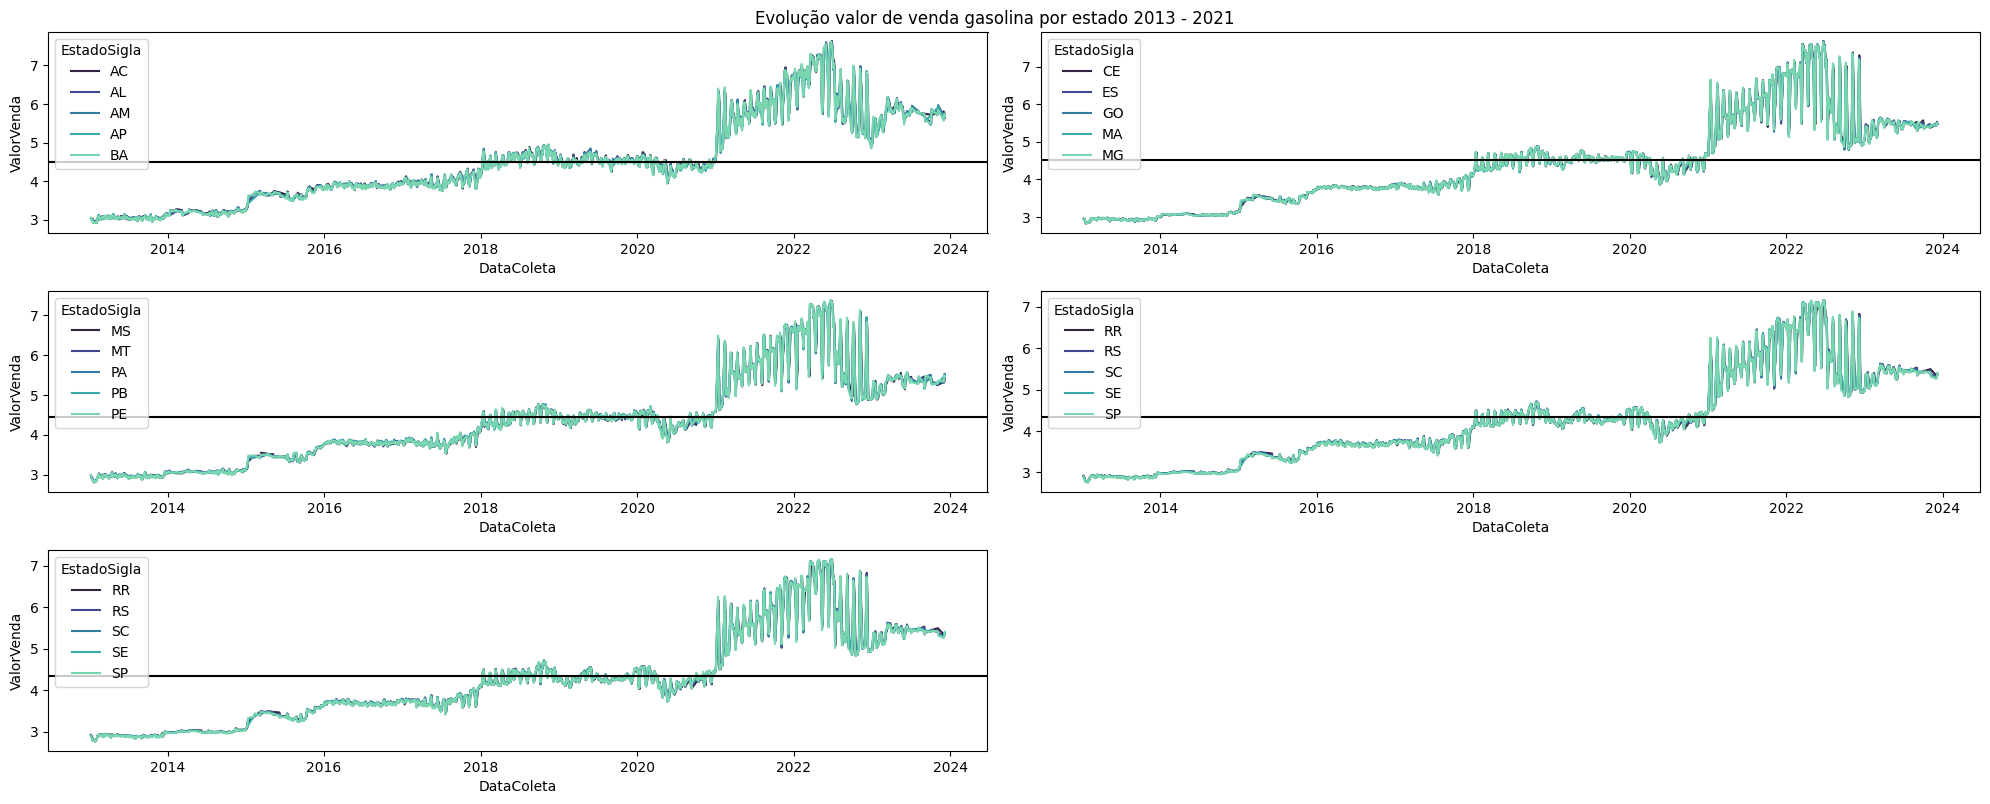

In [15]:
#Pegando 27 Estados
estados = list(media_compra.index.get_level_values(1).unique()) 

#==================================================================================================================================

plt.figure(figsize = (20, 13)).suptitle('Evolução valor de compra gasolina por estado 2013 - 2023')
mv_av_periods = 2

plt.subplot(5, 2, 1)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(estados[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_compra_por_estado.png', dpi = 150)
plt.show()


#==================================================================================================================================


plt.figure(figsize = (20, 13)).suptitle('Evolução valor de venda gasolina por estado 2013 - 2021')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
tt = media_venda.loc[media_venda.index.get_level_values(1).isin(estados[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'mako'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_venda_por_estado.png', dpi = 150)
plt.show()

#### Conclusões
> - Notou que o formato de todos os gráficos é muito semelhante? Isso é um forte de indício que esses valores não são fortemente influênciados pelo estado, mas sim pelo passagem to tempo em si, pois a evolução vista é praticamente a mesma observada quando analisamos todos os estados agrupados

### Evolução por bandeira (Fornecedor)


In [16]:
media_compra = combustiveis.groupby(by = ['DataColeta', 'Bandeira'])['ValorCompra'].mean()
media_venda = combustiveis.groupby(by = ['DataColeta', 'Bandeira'])['ValorVenda'].mean()

/tmp/ipykernel_19473/2504320133.py:55: UserWarning: Glyph 141 (\x8d) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19473/2504320133.py:55: UserWarning: Glyph 130 (\x82) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19473/2504320133.py:56: UserWarning: Glyph 141 (\x8d) missing from current font.
  plt.savefig('evolução_compra_por_bandeira.png', dpi = 150)
/tmp/ipykernel_19473/2504320133.py:56: UserWarning: Glyph 130 (\x82) missing from current font.
  plt.savefig('evolução_compra_por_bandeira.png', dpi = 150)
/media/jorge/HDD/Python/combustiveis/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/media/jorge/HDD/Python/combustiveis/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


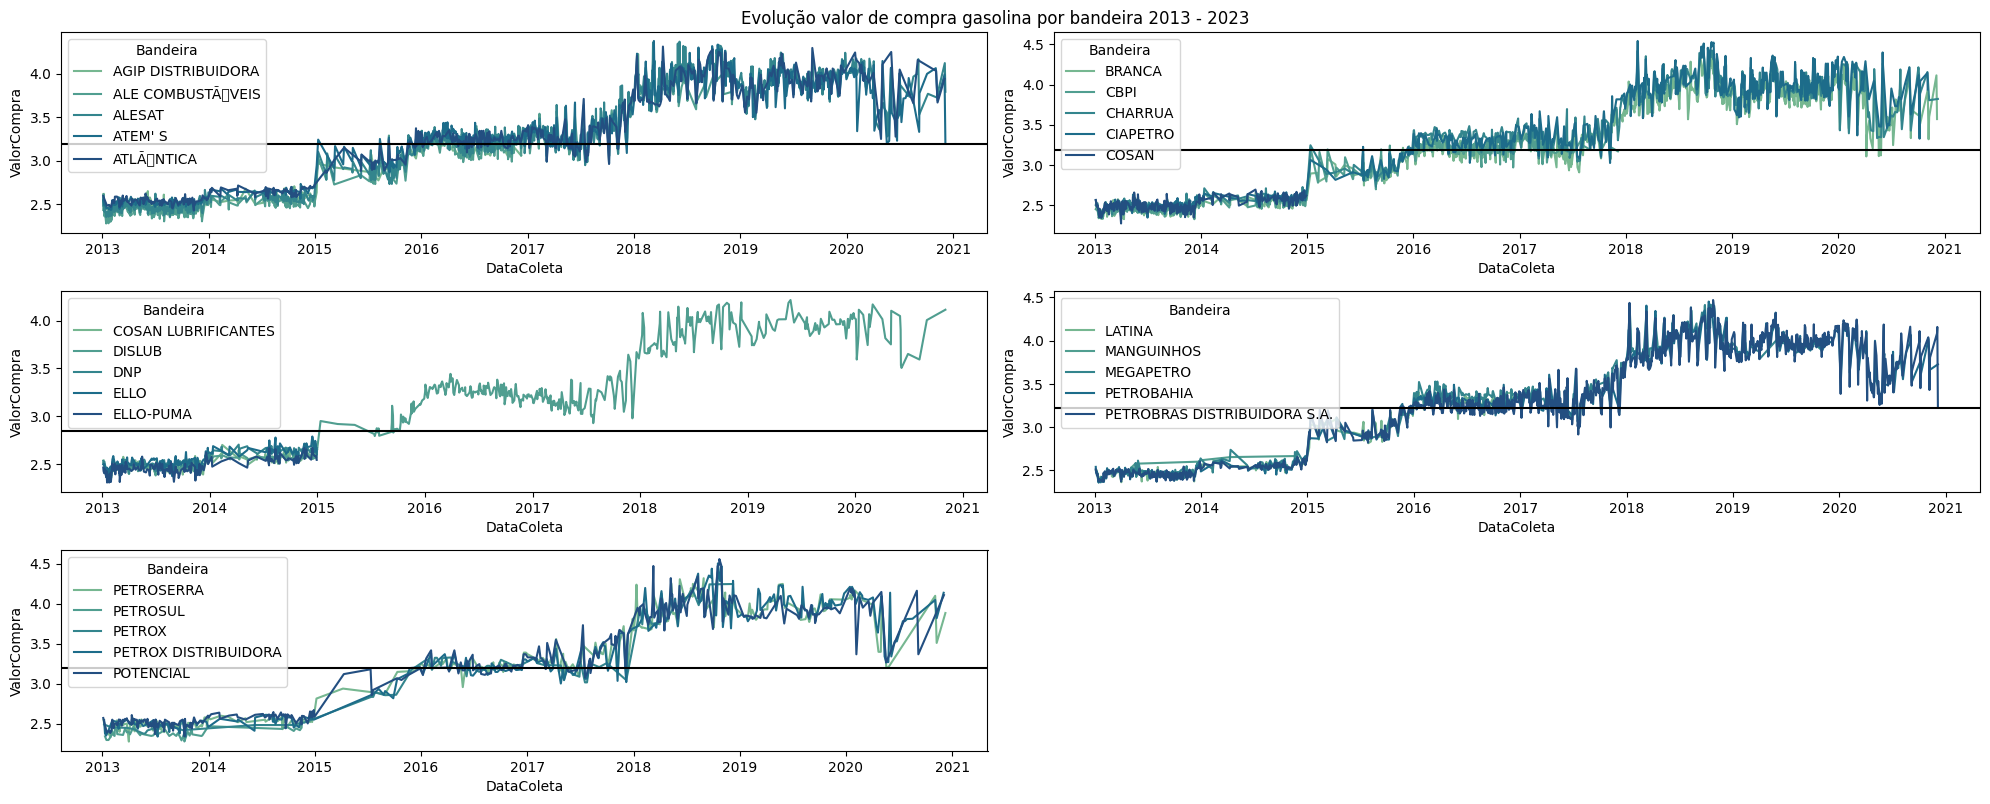

/tmp/ipykernel_19473/2504320133.py:115: UserWarning: Glyph 141 (\x8d) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19473/2504320133.py:115: UserWarning: Glyph 130 (\x82) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19473/2504320133.py:116: UserWarning: Glyph 141 (\x8d) missing from current font.
  plt.savefig('evolução_venda_por_bandeira.png', dpi = 150)
/tmp/ipykernel_19473/2504320133.py:116: UserWarning: Glyph 130 (\x82) missing from current font.
  plt.savefig('evolução_venda_por_bandeira.png', dpi = 150)
/media/jorge/HDD/Python/combustiveis/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 141 (\x8d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/media/jorge/HDD/Python/combustiveis/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


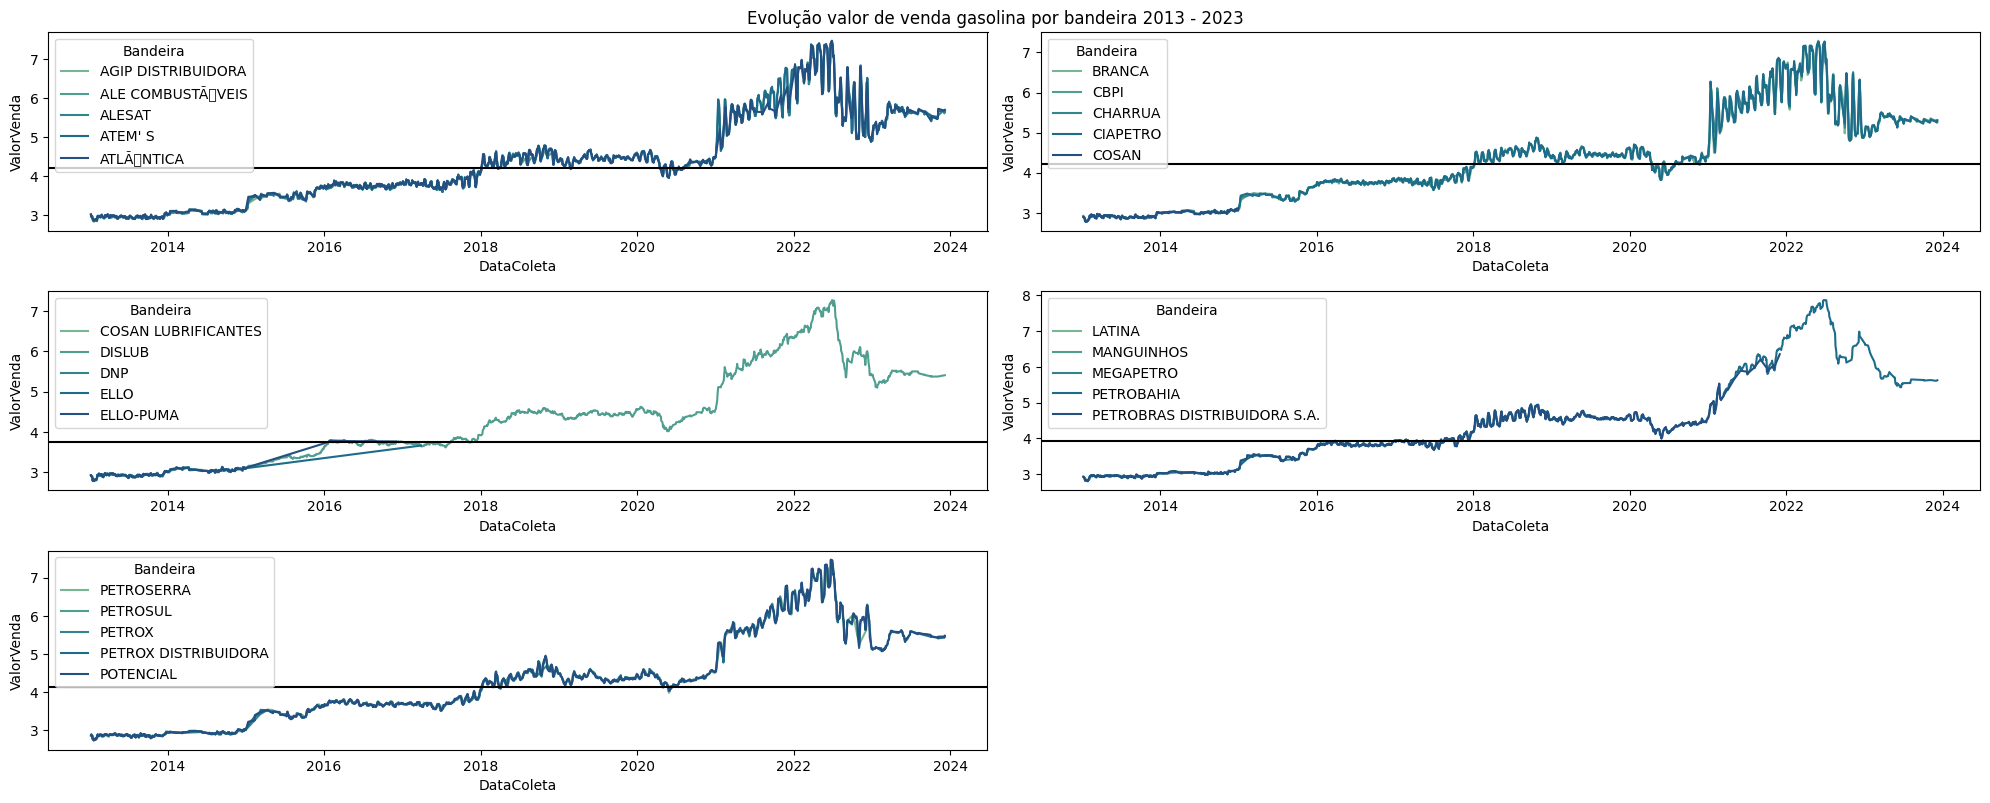

In [17]:
bandeiras = list(media_compra.index.get_level_values(1).unique()) 

plt.figure(figsize = (20, 13)).suptitle('Evolução valor de compra gasolina por bandeira 2013 - 2023')
mv_av_periods = 2

plt.subplot(5, 2, 1)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_compra.loc[media_compra.index.get_level_values(1).isin(bandeiras[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_compra_por_bandeira.png', dpi = 150)
plt.show()


#------------------------------------------------------------------------------------------------------------------------------------------------------------


plt.figure(figsize = (20, 13)).suptitle('Evolução valor de venda gasolina por bandeira 2013 - 2023')
mv_av_periods = 15

plt.subplot(5, 2, 1)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[0:5])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 2)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[5:10])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 3)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[10:15])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 4)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[20:25])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')


plt.subplot(5, 2, 5)
data_sliced = media_venda.loc[media_venda.index.get_level_values(1).isin(bandeiras[25:30])]
sb.lineplot(x = data_sliced.index.get_level_values(0),
            y = data_sliced.rolling(mv_av_periods).mean(),
            hue = data_sliced.index.get_level_values(1),
            palette = 'crest'
           )
plt.axhline(data_sliced.mean(), color = 'black')

plt.tight_layout()
plt.savefig('evolução_venda_por_bandeira.png', dpi = 150)
plt.show()

#### Conclusões
>-Semelhante a análise por estado, as bandeiras ao longo do tempo não demonstraram diferença significativa entre si.

# Simulando Valores de Compra Faltantes

In [18]:
combustiveis_v2 = read_data('GASOLINA', path = '/media/jorge/HDD/Python/combustiveis/dados_historicos/')

#Conversões de tipo de dados
float_converter(['ValorCompra','ValorVenda'], combustiveis_v2)
add_dates(['DataColeta'], combustiveis_v2)

#Calculando Margem de lucro
add_mrg('ValorVenda', 'ValorCompra', combustiveis_v2)

Uma excessão ocorreu porque ValorCompra é do tipo <class 'numpy.dtypes.Float64DType'>
ValorVenda convertido com sucesso para <class 'numpy.dtypes.Float64DType'>


'Coluna Margem Adicionada'

## Simulando margens aleatórias

In [19]:
combustiveis_v2['mrg'].fillna(np.random.uniform(0.05, 0.16), inplace = True)

In [20]:
combustiveis_v2['ValorCompra'].fillna(combustiveis_v2['ValorVenda'] - combustiveis_v2['mrg']*combustiveis_v2['ValorVenda'], inplace = True)

## Analisando Cenário Simulado

In [21]:
combustiveis_v2[colunas_quantitativas].describe().round(3)

,ValorVenda,ValorCompra,mrg
count,2703118.000,2703118.000,2703118.000
mean,4.165,3.641,0.126
std,1.149,1.016,0.023
min,2.229,1.974,-0.163
25%,3.199,2.790,0.125
50%,3.989,3.490,0.125
75%,4.699,4.150,0.125
max,8.990,7.871,0.414


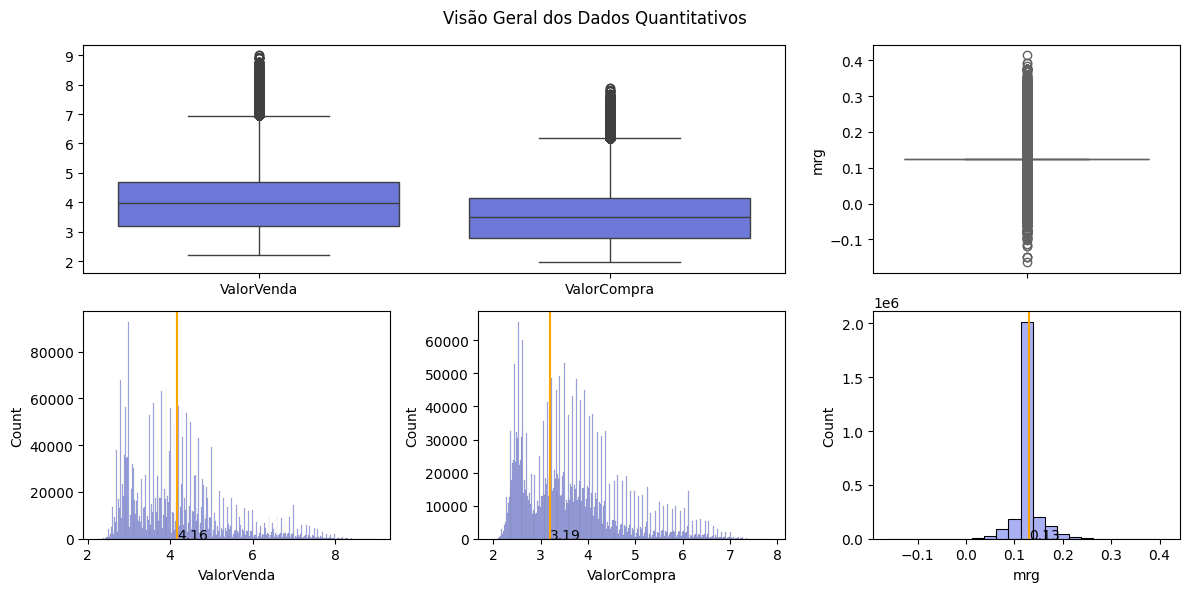

In [22]:
plt.figure(figsize = (12, 6)).suptitle('Visão Geral dos Dados Quantitativos')

plt.subplot(2, 3, (1, 2))
sb.boxplot(combustiveis_v2[colunas_quantitativas[0:2]], color = cor_roxo_padrao)

plt.subplot(2, 3, (3))
sb.boxplot(combustiveis_v2[colunas_quantitativas[-1]], color = cor_roxo_padrao)

plt.subplot(2, 3, (4))
sb.histplot(combustiveis_v2['ValorVenda'], color = cor_roxo_claro)
media = combustiveis['ValorVenda'].mean()
plt.axvline(media, color = 'orange')
plt.text(x = media, y = 0, s = round(media, 2))
plt.axvline(media, color = 'orange')

plt.subplot(2, 3, (5))
sb.histplot(combustiveis_v2['ValorCompra'], color = cor_roxo_claro)
media = combustiveis['ValorCompra'].mean()
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')

plt.subplot(2, 3, (6))
sb.histplot(combustiveis_v2['mrg'], color = cor_roxo_claro)
media = combustiveis['mrg'].mean()
plt.text(x = media, y = 0, s = round(media, 2)) 
plt.axvline(media, color = 'orange')

plt.tight_layout()
plt.savefig('visao_geral_dados_quant_v2.png', dpi = 150)
plt.show()

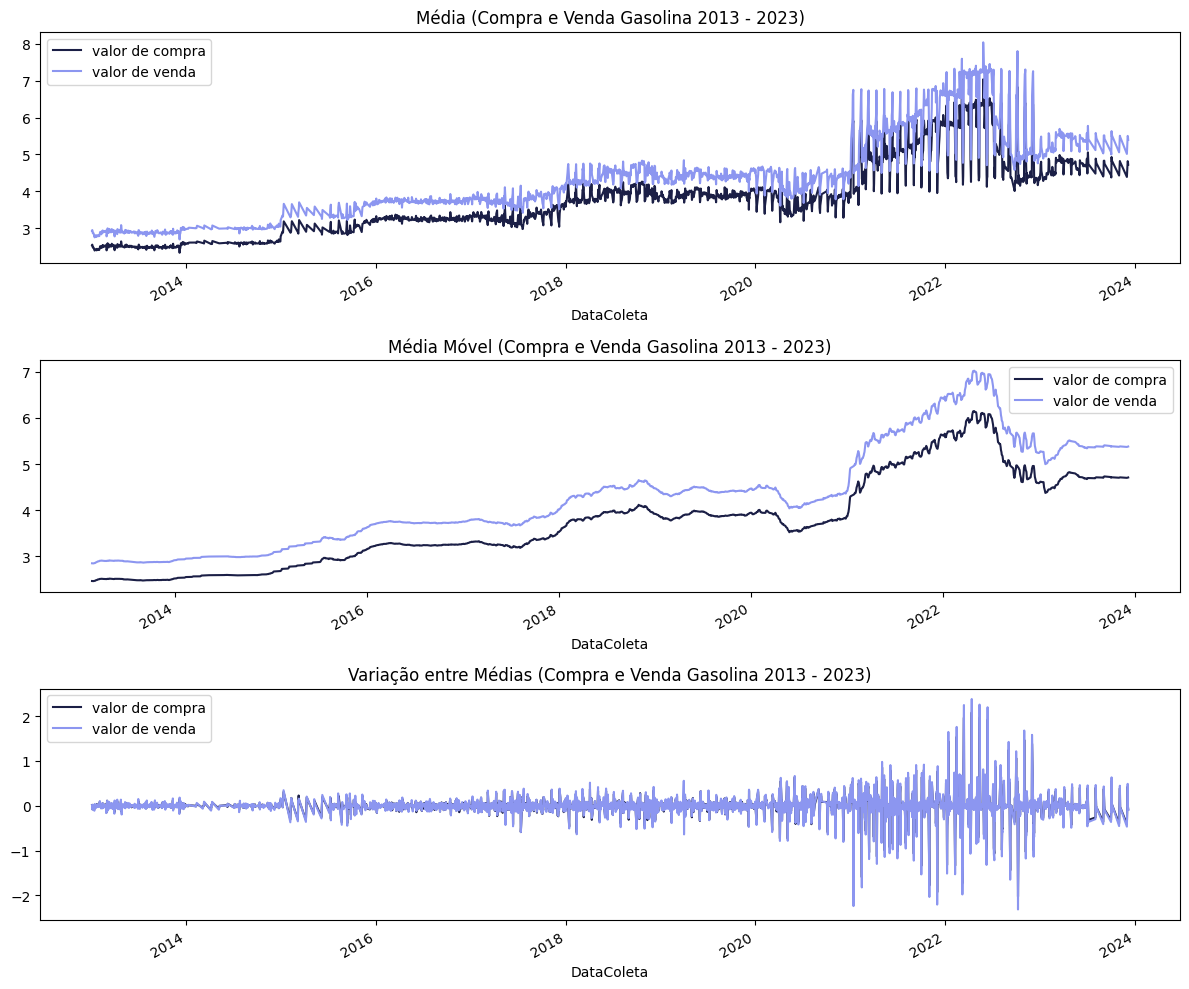

In [23]:
media_compra = combustiveis_v2.groupby(by = 'DataColeta')['ValorCompra'].mean()
media_venda = combustiveis_v2.groupby(by = 'DataColeta')['ValorVenda'].mean()

num_rows = 3
num_col = 1

plt.figure(figsize = (12, 10))

plt.subplot(num_rows, num_col, 1)
plt.title('Média (Compra e Venda Gasolina 2013 - 2023)')
media_compra.plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.subplot(num_rows, num_col ,2)
plt.title('Média Móvel (Compra e Venda Gasolina 2013 - 2023)')
media_compra.rolling(30).mean().plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.rolling(30).mean().plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.subplot(num_rows, num_col, 3)
plt.title('Variação entre Médias (Compra e Venda Gasolina 2013 - 2023)')
media_compra.diff().plot(label = 'valor de compra', color = cor_roxo_escuro)
media_venda.diff().plot(label = 'valor de venda', color = cor_roxo_claro)
plt.legend()

plt.tight_layout()
plt.savefig('analise_serie_v2.png', dpi=150)
plt.show()
